In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (필요시)
import matplotlib.font_manager as fm

# 나눔고딕 폰트 설정 (시스템에 설치되어 있다고 가정)
try:
    plt.rc('font', family='Malgun Gothic')
    plt.rcParams['axes.unicode_minus'] = False
except:
    print("맑은고딕 폰트가 설치되어 있지 않습니다. 기본 폰트를 사용합니다.")

In [2]:
# 1. 65세 이상 노인 인구 데이터 (2015-2024)
years = np.array(range(2015, 2025))
elder_population = np.array([
    33555,
    35214,
    36991,
    38468,
    40246,
    42471,
    43949,
    45985,
    48395,
    50571
])

# 2. 경로당 개수 데이터 (일부만 있음: 2017, 2023, 2024)
known_years = np.array([2020, 2021, 2022, 2023, 2024])
known_centers = np.array([231, 231, 237, 240, 236])  # 해당 연도의 경로당 개수

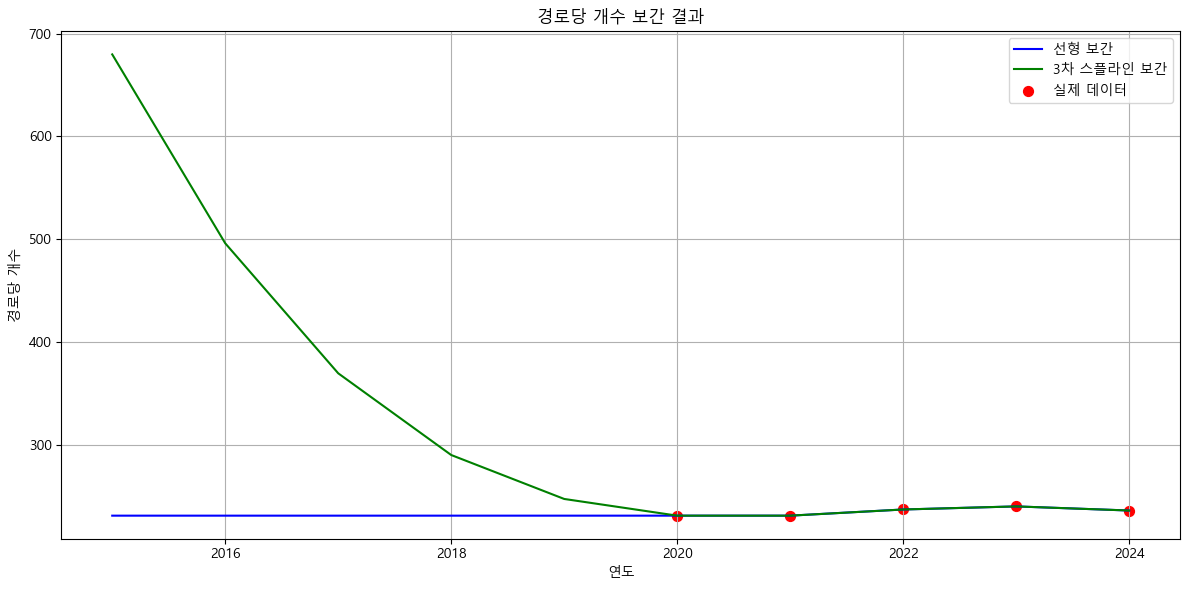

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0068
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025     
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033     
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016     
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011     
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010     
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018     
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014     
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1237e-04 
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.8285e-04 
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.3596e-04 
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

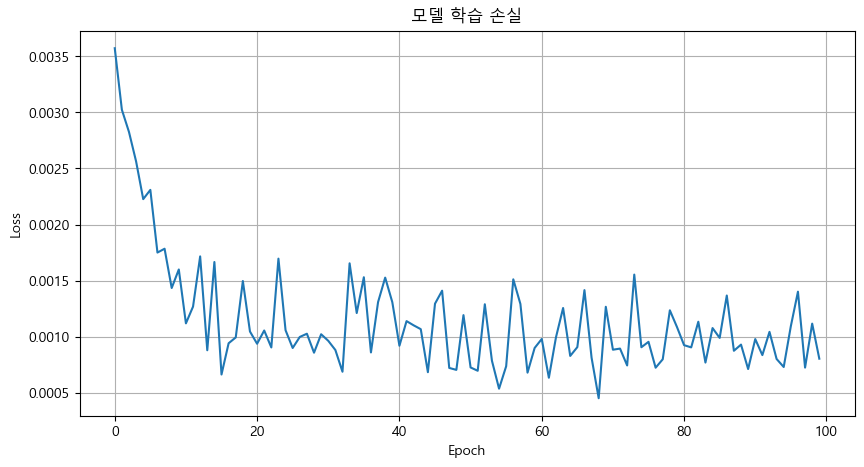

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

예측 결과 비교:
   Year  Actual   Predicted      Error  Error_Percent
0  2023   240.0  219.057831  20.942169       8.725904
1  2024   236.0  214.459839  21.540161       9.127187

평가 지표:
평균 절대 오차 (MAE): 21.24
평균 제곱 오차 (MSE): 451.28
평균 제곱근 오차 (RMSE): 21.24
결정계수 (R²): -111.8191


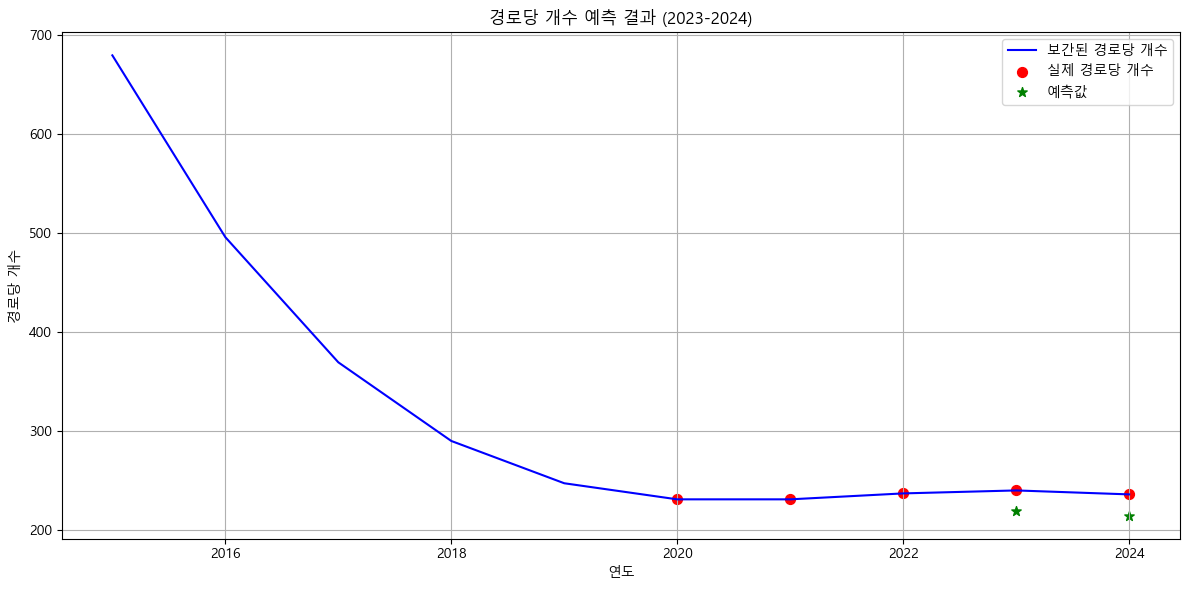

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

미래 경로당 개수 예측 결과:
   Year  Predicted_Elder_Population  Predicted_Centers
0  2025                51886.133333         210.257828
1  2026                53759.157576         207.058228
2  2027                55632.181818         205.307266
3  2028                57505.206061         204.652542
4  2029                59378.230303         204.082550
5  2030                61251.254545         203.906418


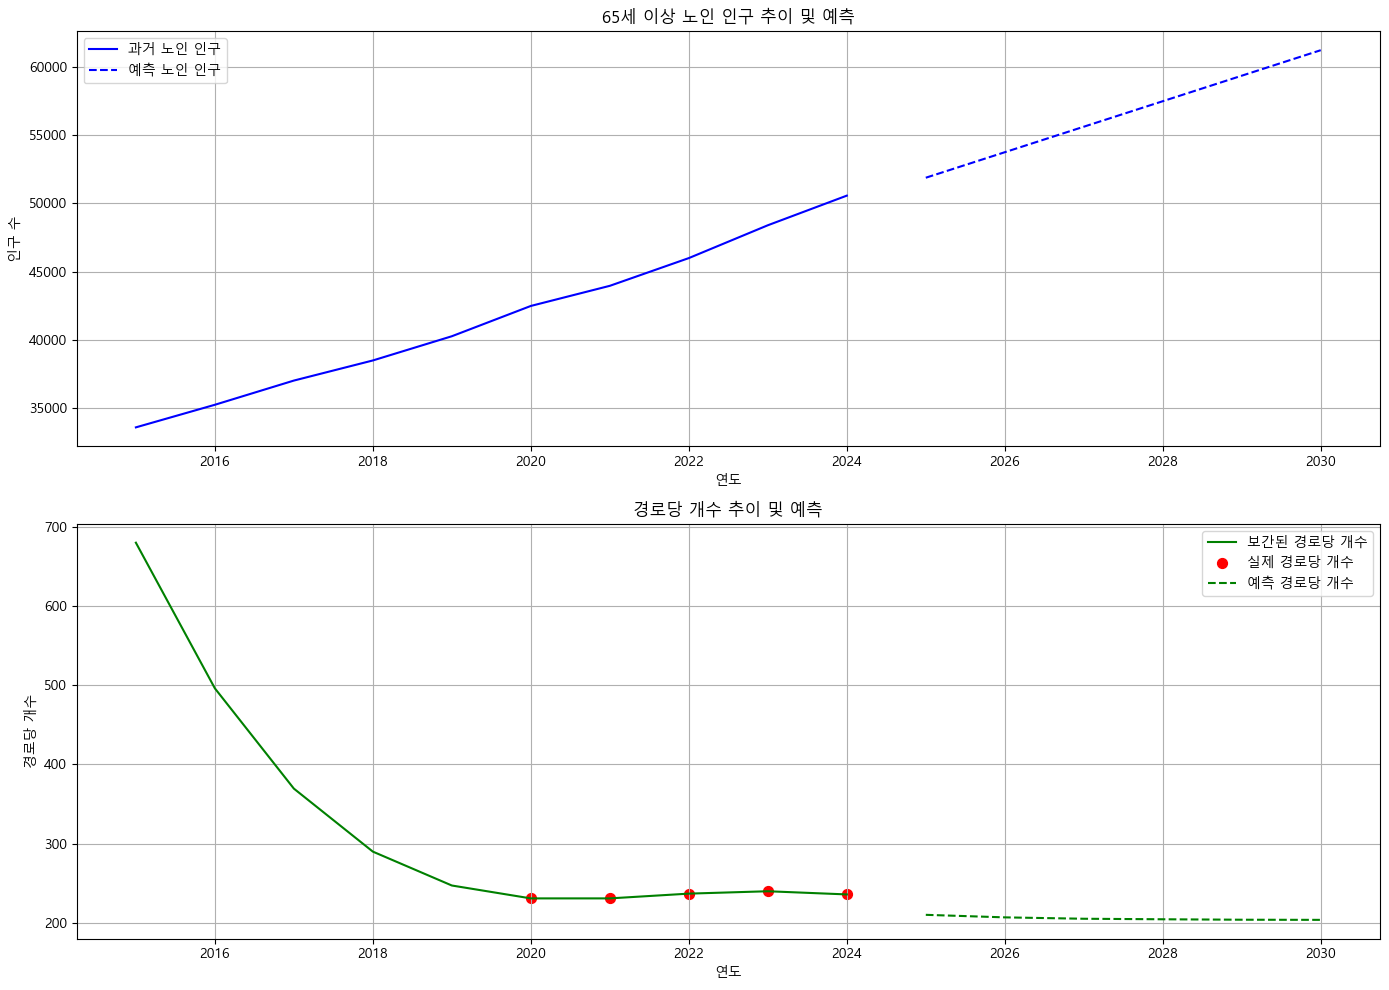

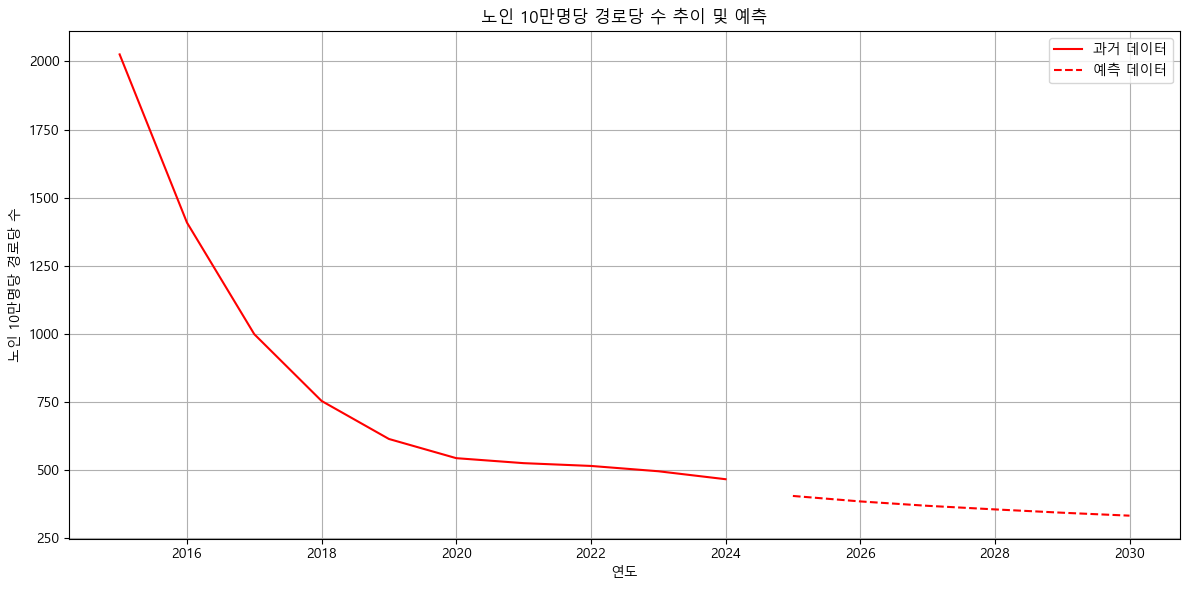


분석 요약:
1. 2023-2024년 예측의 평균 오차율: 8.93%
2. 2030년까지의 예측 경로당 증가율: -13.60%
3. 노인 인구 10만명당 경로당 수 변화:
   - 2015년: 2025.78개
   - 2024년: 466.67개
   - 2030년(예측): 332.90개


In [3]:
# 데이터프레임 생성
df = pd.DataFrame({
    'year': years,
    'elder_population': elder_population
})

# 보간법을 사용하여 누락된 경로당 개수 데이터 채우기
# 선형 보간법 사용
f_linear = interpolate.interp1d(known_years, known_centers, kind='linear', fill_value='extrapolate')
interpolated_centers_linear = f_linear(years)

# 3차 스플라인 보간법
if len(known_years) >= 3:  # 최소 3개 이상의 데이터 포인트가 필요
    f_cubic = interpolate.interp1d(known_years, known_centers, kind='cubic', fill_value='extrapolate')
    interpolated_centers_cubic = f_cubic(years)
else:
    interpolated_centers_cubic = interpolated_centers_linear

# 보간된 값을 데이터프레임에 추가
df['centers_linear'] = interpolated_centers_linear
df['centers_cubic'] = interpolated_centers_cubic

# 실제 값은 알고 있는 연도에만 표시
df['centers_actual'] = np.nan
for year, center in zip(known_years, known_centers):
    df.loc[df['year'] == year, 'centers_actual'] = center

# 보간법 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(df['year'], df['centers_linear'], 'b-', label='선형 보간')
plt.plot(df['year'], df['centers_cubic'], 'g-', label='3차 스플라인 보간')
plt.scatter(known_years, known_centers, color='red', s=50, label='실제 데이터')
plt.title('경로당 개수 보간 결과')
plt.xlabel('연도')
plt.ylabel('경로당 개수')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 보간법 중 선택 (3차 스플라인 보간법 선택)
df['centers'] = df['centers_cubic']

# 모델 성능 평가를 위해 2023년과 2024년 데이터 분리
train_df = df[df['year'] <= 2022].copy()
test_df = df[df['year'] > 2022].copy()

# LSTM 모델 구축을 위한 데이터 전처리 함수
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# 데이터 정규화
scaler_pop = MinMaxScaler()
scaler_centers = MinMaxScaler()

# 학습 데이터 정규화
train_df['scaled_population'] = scaler_pop.fit_transform(train_df[['elder_population']])
train_df['scaled_centers'] = scaler_centers.fit_transform(train_df[['centers']])

# 테스트 데이터 정규화
test_df['scaled_population'] = scaler_pop.transform(test_df[['elder_population']])
test_df['scaled_centers'] = scaler_centers.transform(test_df[['centers']])

# LSTM을 위한 시퀀스 데이터 준비
seq_length = 3  # 시퀀스 길이 (3년 데이터로 다음 해 예측)

# 학습 데이터 시퀀스 생성
X_train_pop, _ = create_sequences(train_df['scaled_population'].values, seq_length)
X_train_pop = X_train_pop.reshape(X_train_pop.shape[0], X_train_pop.shape[1], 1)

_, y_train = create_sequences(train_df['scaled_centers'].values, seq_length)
y_train = y_train.reshape(-1, 1)

# LSTM 모델 구축
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
history = model.fit(X_train_pop, y_train, epochs=100, batch_size=1, verbose=1)

# 학습 과정 시각화
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.title('모델 학습 손실')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# 2023년과 2024년 예측 (모델 검증용)
def predict_next_year(model, last_sequence, scaler):
    pred = model.predict(last_sequence.reshape(1, seq_length, 1))
    return scaler.inverse_transform(pred)[0, 0]

# 2023년 예측을 위한 마지막 시퀀스 (2020-2022)
last_sequence = train_df['scaled_population'].values[-seq_length:]

# 2023년 예측
pred_2023_scaled = model.predict(last_sequence.reshape(1, seq_length, 1))
pred_2023 = scaler_centers.inverse_transform(pred_2023_scaled)[0, 0]

# 2024년 예측을 위한 시퀀스 (2021-2023)
next_sequence = np.append(last_sequence[1:], 
                          scaler_pop.transform([[test_df['elder_population'].values[0]]])[0, 0])

# 2024년 예측
pred_2024_scaled = model.predict(next_sequence.reshape(1, seq_length, 1))
pred_2024 = scaler_centers.inverse_transform(pred_2024_scaled)[0, 0]

# 예측 결과와 실제 값 비교
results_df = pd.DataFrame({
    'Year': [2023, 2024],
    'Actual': [df.loc[df['year'] == 2023, 'centers_actual'].values[0], 
               df.loc[df['year'] == 2024, 'centers_actual'].values[0]],
    'Predicted': [pred_2023, pred_2024]
})

# 예측 오차 계산
results_df['Error'] = results_df['Actual'] - results_df['Predicted']
results_df['Error_Percent'] = (results_df['Error'] / results_df['Actual']) * 100

print("\n예측 결과 비교:")
print(results_df)

# 평가 지표 계산
mae = mean_absolute_error(results_df['Actual'], results_df['Predicted'])
mse = mean_squared_error(results_df['Actual'], results_df['Predicted'])
rmse = np.sqrt(mse)
r2 = r2_score(results_df['Actual'], results_df['Predicted'])

print(f"\n평가 지표:")
print(f"평균 절대 오차 (MAE): {mae:.2f}")
print(f"평균 제곱 오차 (MSE): {mse:.2f}")
print(f"평균 제곱근 오차 (RMSE): {rmse:.2f}")
print(f"결정계수 (R²): {r2:.4f}")

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(df['year'], df['centers'], 'b-', label='보간된 경로당 개수')
plt.scatter(known_years, known_centers, color='red', s=50, label='실제 경로당 개수')
plt.scatter([2023, 2024], results_df['Predicted'], color='green', s=50, marker='*', label='예측값')
plt.title('경로당 개수 예측 결과 (2023-2024)')
plt.xlabel('연도')
plt.ylabel('경로당 개수')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 미래 예측 (2025-2030)
future_years = np.array(range(2025, 2031))

# 미래 노인 인구 예측 (간단한 선형 추세로 예측)
# 실제로는 더 정교한 인구 예측 모델 사용 권장
population_trend = np.polyfit(years, elder_population, 1)
future_population = np.polyval(population_trend, future_years)

# 미래 인구 데이터 정규화
future_population_scaled = scaler_pop.transform(future_population.reshape(-1, 1))

# 미래 경로당 개수 예측
future_centers = []

# 2025년 예측을 위한 시퀀스 (2022-2024의 인구)
last_seq = np.array([
    train_df['scaled_population'].values[-1],
    scaler_pop.transform([[test_df['elder_population'].values[0]]])[0, 0],
    scaler_pop.transform([[test_df['elder_population'].values[1]]])[0, 0]
])

for i in range(len(future_years)):
    # 현재 시퀀스로 다음 년도 예측
    next_center_scaled = model.predict(last_seq.reshape(1, seq_length, 1))
    next_center = scaler_centers.inverse_transform(next_center_scaled)[0, 0]
    future_centers.append(next_center)
    
    # 시퀀스 업데이트 (가장 오래된 항목 제거하고 새 데이터 추가)
    last_seq = np.append(last_seq[1:], future_population_scaled[i])

# 미래 예측 결과 데이터프레임
future_df = pd.DataFrame({
    'Year': future_years,
    'Predicted_Elder_Population': future_population,
    'Predicted_Centers': future_centers
})

print("\n미래 경로당 개수 예측 결과:")
print(future_df)

# 과거 데이터와 미래 예측 결과 시각화
plt.figure(figsize=(14, 10))

# 서브플롯 1: 노인 인구 추이
plt.subplot(2, 1, 1)
plt.plot(years, elder_population, 'b-', label='과거 노인 인구')
plt.plot(future_years, future_population, 'b--', label='예측 노인 인구')
plt.title('65세 이상 노인 인구 추이 및 예측')
plt.xlabel('연도')
plt.ylabel('인구 수')
plt.legend()
plt.grid(True)

# 서브플롯 2: 경로당 개수 추이
plt.subplot(2, 1, 2)
plt.plot(df['year'], df['centers'], 'g-', label='보간된 경로당 개수')
plt.scatter(known_years, known_centers, color='red', s=50, label='실제 경로당 개수')
plt.plot(future_years, future_centers, 'g--', label='예측 경로당 개수')
plt.title('경로당 개수 추이 및 예측')
plt.xlabel('연도')
plt.ylabel('경로당 개수')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 노인 인구당 경로당 수 계산
df['centers_per_100k'] = (df['centers'] / df['elder_population']) * 100000
future_df['centers_per_100k'] = (future_df['Predicted_Centers'] / future_df['Predicted_Elder_Population']) * 100000

# 노인 10만명당 경로당 수 추이 시각화
plt.figure(figsize=(12, 6))
plt.plot(df['year'], df['centers_per_100k'], 'r-', label='과거 데이터')
plt.plot(future_years, future_df['centers_per_100k'], 'r--', label='예측 데이터')
plt.title('노인 10만명당 경로당 수 추이 및 예측')
plt.xlabel('연도')
plt.ylabel('노인 10만명당 경로당 수')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 결과 요약
print("\n분석 요약:")
print(f"1. 2023-2024년 예측의 평균 오차율: {results_df['Error_Percent'].abs().mean():.2f}%")
print(f"2. 2030년까지의 예측 경로당 증가율: {((future_centers[-1] / df['centers'].values[-1]) - 1) * 100:.2f}%")
print(f"3. 노인 인구 10만명당 경로당 수 변화:")
print(f"   - 2015년: {df['centers_per_100k'].values[0]:.2f}개")
print(f"   - 2024년: {df['centers_per_100k'].values[-1]:.2f}개")
print(f"   - 2030년(예측): {future_df['centers_per_100k'].values[-1]:.2f}개")